### Summary
In this notebook I compare the effect of two rotation functions. During most of the experiments I had used from scipy.misc.imrotate which turns out to induce artefacts because it rescales the images to [0, 256] (as opposed to the [0,1] scaling of the original dataset). When creating the datasets, make sure to use the updated verion of the create_datasets function, which uses scipy.ndimage.interpolation.rotate

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
import pickle

from functions.build_constant_network import build_network
from functions.multiple_bar_plot import multiple_bar_plot

import random
import copy


PATH = '/home/claudia/Dokumente/Uni/lab_rotation_TU/compare_AER_AEUR'

In [16]:
AER_file = PATH + '/network_params/AER_finetuned_params_complete.p'
AER_params = pickle.load(open(AER_file, 'rb'))

W_AER = AER_params['weights_incl_softmax']
B_AER = AER_params['bias_incl_softmax']

x_AER, y_AER, weights_AER, bias_AER, activations_AER, measures_AER = \
build_network(W_AER, B_AER) 

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [17]:
DATA = pickle.load(open(PATH +'/datasets/all_rotated_data_info.p', 'rb'))
LABELS = DATA['labels']

mnist = DATA['mnist']
mnist_mix = DATA['mnist_mix'] #roatation angle is randomly chosen from np.arange(-90, 90, 15)

### Comparison of the two rotation functions

In [18]:
from scipy.misc import imrotate                # will be referenced as rot_1
from scipy.ndimage.interpolation import rotate # will be referenced as rot_2

#### Visual comparison of rot_1 vs. rot_2 at angle = 0

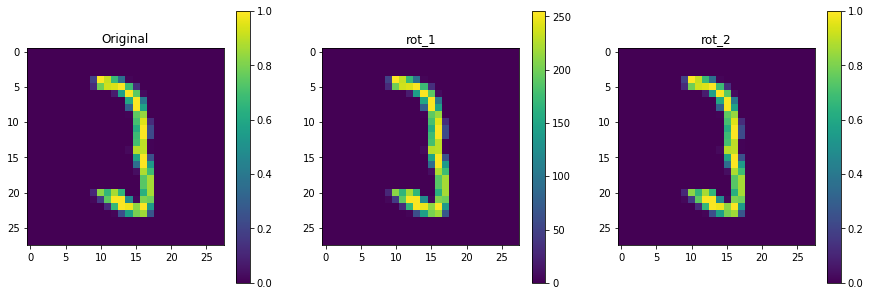

In [19]:
idx = random.randint(0, 10000)

im = np.reshape(mnist[idx], (28,28))
im_rot1 = imrotate(im, 0, interp='bilinear')
im_rot2 = rotate(im, 0, reshape = False)
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.imshow(im)
plt.colorbar()
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(im_rot1)
plt.colorbar()
plt.title('rot_1')


plt.subplot(1,3,3)
plt.imshow(im_rot2)
plt.colorbar()
plt.title('rot_2')


plt.show()

#### Euclidian distance of two versions of rotation vs. original

In [20]:
print('original to rot_1 = ', np.sqrt(np.linalg.norm(im-im_rot1)))
print('original to rot_2 = ', np.sqrt(np.linalg.norm(im-im_rot2)))

original to rot_1 =  40.1189
original to rot_2 =  1.87062e-08


#### Create dataset MNIST_new using only rot_2

In [21]:
DATA_POINTS = len(mnist)
DATA_SHAPE = mnist.shape

angles = range(-90,90+1,15)
phis = np.zeros(DATA_POINTS)
mnist_new = np.zeros(DATA_SHAPE)

for i in range(DATA_POINTS):
    im = np.reshape(mnist[i], (28,28))
    phi = random.sample(angles,1)[0]
    phis[i] = phi
    
    im_rot = rotate(im, phi, reshape = False)
    mnist_new[i] = np.reshape(im_rot, (784,))



#### difference in classification accuracy of rot_1 vs rot_2

In [22]:
b = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist_mix.T, y_AER: LABELS.T})
c = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist_new.T, y_AER: LABELS.T})

print('rot_1 (scipy.misc.imrotate): ', b)
print('rot_2 (scipy.ndimage.interpolation.rotate): ', c)

rot_1 (scipy.misc.imrotate):  0.5887
rot_2 (scipy.ndimage.interpolation.rotate):  0.7257


In [23]:
iterations = 10
percentage = [i for i in range(10)]

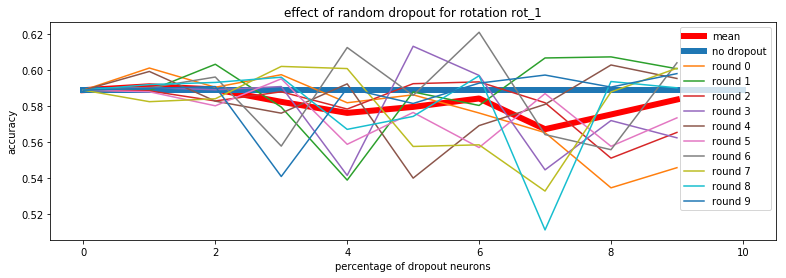

In [24]:
acc = np.zeros((iterations, len(percentage)))
for p in percentage: 
    for j in range(iterations):
        neurons = random.sample(range(256), p)
        WW_mix = copy.deepcopy(W_AER)
        WW_mix[3][:, neurons] = 0
        b = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist_mix.T, y_AER: LABELS.T, \
                                                        weights_AER['W_h4']:WW_mix[3]})
        acc[j, p] = b 
    
plt.figure(figsize = (13, 4))
plt.plot(np.mean(acc, axis = 0), 'r', linewidth = 6, label = 'mean')
plt.plot([0, len(percentage)], [acc[0,0], acc[0,0]],  linewidth = 6, label = 'no dropout')
for j in range(iterations):
    plt.plot(acc[j, :], label = 'round '+ str(j))
plt.legend()
plt.title('effect of random dropout for rotation rot_1')
plt.xlabel('percentage of dropout neurons')
plt.ylabel('accuracy')
plt.show()

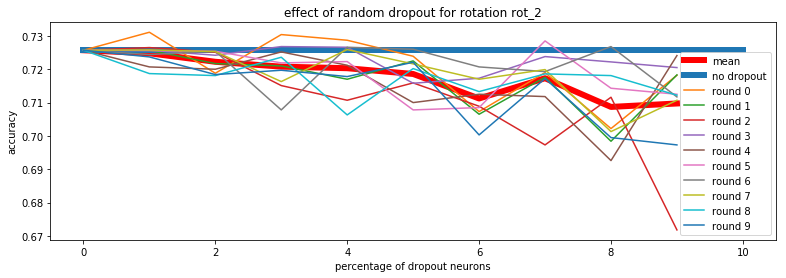

In [25]:
acc = np.zeros((iterations, len(percentage)))
for p in percentage: 
    for j in range(iterations):
        neurons = random.sample(range(256), p)
        WW_mix = copy.deepcopy(W_AER)
        WW_mix[3][:, neurons] = 0
        b = sess.run(measures_AER['accuracy'], feed_dict = {x_AER: mnist_new.T, y_AER: LABELS.T, \
                                                        weights_AER['W_h4']:WW_mix[3]})
        acc[j, p] = b 
    
plt.figure(figsize = (13, 4))
plt.plot(np.mean(acc, axis = 0), 'r', linewidth = 6, label = 'mean')
plt.plot([0, len(percentage)], [acc[0,0], acc[0,0]],  linewidth = 6, label = 'no dropout')
for j in range(iterations):
    plt.plot(acc[j, :], label = 'round '+ str(j))
plt.legend()
plt.title('effect of random dropout for rotation rot_2')
plt.xlabel('percentage of dropout neurons')
plt.ylabel('accuracy')
plt.show()